In [2]:
import os
from glob import glob
import random
from pathlib import Path
import pickle
from functools import partial
import numpy as np
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();
from IPython.display import clear_output
from celluloid import Camera

from sage.training.trainer import MRITrainer
from sage.visualization.vistool import plot_vismap
from sage.visualization.utils import check_type
from sage.config import load_config
from utils.analysis import (
    Result, FileSelector, 
    group_stats, cherry_picker, check_existence, save2nifti, MAE, transform
)

In [3]:
AVG = np.load("./data/average.npy")
naive_sel = FileSelector("naive")
gt_result = np.array(naive_sel.test_gt)
epoch_parser = lambda path: int(path.split("/layer0/ep")[-1].split("_mae")[0])
mae_parser = lambda path: float(path.split("_mae")[-1].split(".npy")[0])

In [4]:
with open("./data/naive_reg_test_100.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_reg_test_100.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [5]:
with open("./data/naive_nonreg_test_100.pkl", "rb") as f:
    naive_nonreg_results = pickle.load(f)
    naive_nonreg_results = {e[0]: e[1] for e in sorted(naive_nonreg_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_nonreg_test_100.pkl", "rb") as f:
    augment_nonreg_results = pickle.load(f)
    augment_nonreg_results = {e[0]: e[1] for e in sorted(augment_nonreg_results.items(), key=lambda x: x[0])}

In [6]:
naive = Result(naive_results)
augment = Result(augment_results)

naive_nonreg = Result(naive_nonreg_results)
augment_nonreg = Result(augment_nonreg_results)

In [7]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()]

In [8]:
last_values_naive_nonreg = [e[-1][1] for e in naive_nonreg.raw_data.values()]
last_values_augment_nonreg = [e[-1][1] for e in augment_nonreg.raw_data.values()]

best_values_naive_nonreg = [min(_[1] for _ in e) for e in naive_nonreg.raw_data.values()]
best_values_augment_nonreg = [min(_[1] for _ in e) for e in augment_nonreg.raw_data.values()]

earlystopped_values_naive_nonreg = [e[-20][1] for e in naive_nonreg.raw_data.values()]
earlystopped_values_augment_nonreg = [e[-20][1] for e in augment_nonreg.raw_data.values()]

total_train_naive_nonreg = [len(e) for e in naive_nonreg.raw_data.values()]
total_train_augment_nonreg = [len(e) for e in augment_nonreg.raw_data.values()]

best_indices_naive_nonreg = [sorted(e, key=lambda x: x[1])[0][0] for e in naive_nonreg.raw_data.values()]
best_indices_augment_nonreg = [sorted(e, key=lambda x: x[1])[0][0] for e in augment_nonreg.raw_data.values()]

Text(0, 0.5, 'Counts')

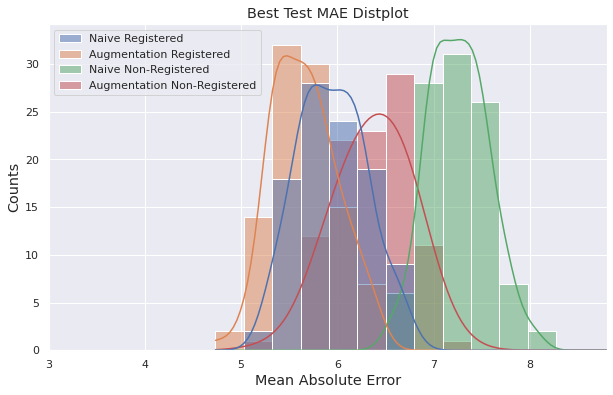

In [9]:
import pandas as pd
best_mae_df = pd.DataFrame({
    "Naive Registered": best_values_naive,
    "Augmentation Registered": best_values_augment,
    "Naive Non-Registered": best_values_naive_nonreg,
    "Augmentation Non-Registered": best_values_augment_nonreg,
})

fig, ax = plt.subplots(figsize=(10, 6))

# sns.histplot(best_mae_df["Naive Registered"], label="Naive Registered", kde=True, ax=ax);
# sns.histplot(best_mae_df["Augmentation Registered"], label="Augmentation Registered", kde=True, ax=ax);
# sns.histplot(best_mae_df["Naive Non-Registered"], label="Naive Non-Registered", kde=True, ax=ax);
# sns.histplot(best_mae_df["Augmentation Non-Registered"], label="Augmentation Non-Registered", kde=True, ax=ax);
sns.histplot(best_mae_df, kde=True, legend=True, ax=ax);

ax.set_xlim(3, 8.8)
ax.set_title("Best Test MAE Distplot", size="large")
ax.set_xlabel("Mean Absolute Error", size="large")
ax.set_ylabel("Counts", size="large")

## Make checkpoints

for first 3 epoch, 50 / 30~40 / 20 / 10-

In [10]:
pct = .9
percentage_indices = {
    "naive": [min(round(e * pct), e-1) for e in total_train_naive],
    "augment": [min(round(e * pct), e-1) for e in total_train_augment],
    "naive_nonreg": [min(round(e * pct), e-1) for e in total_train_naive_nonreg],
    "augment_nonreg": [min(round(e * pct), e-1) for e in total_train_augment_nonreg],
}

0, 1, 2

54.564, 45.84, 23.27, 

8 7.5 6.5 6.0 best

In [11]:
from skimage.filters import gaussian

def mean(lst):

    try: 
        return sum(lst) / len(lst)
    except:
        return sum([_[0] for _ in lst]) / len([_[0] for _ in lst])

def find_first_reached(ckpts, point):

    """
    ckpts: list of tuples [(0, MAE0), (1, MAE1), ...]
    point: float
        when the given checkpoint reached the given point for the first time.
    """
    candidate_prev, candidate_next = None, None
    for epoch, mae in ckpts:

        if mae > point:
            candidate_prev = (epoch, mae)
        else:
            candidate_next = (epoch, mae)
            break

    if candidate_prev is None:
        # Every MAE is smaller than the given point
        return (0, -1)
    elif candidate_next is None:
        # Every MAE is larger than 
        return (len(ckpts), -1)
    elif candidate_prev is None and candidate_next is None:
        print("Something is wrong...")
        return None

    if (candidate_prev[1] - point) >= (point - candidate_next[1]):
        return candidate_next
    else:
        return candidate_prev

def first_reached_indices(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    indices = [find_first_reached(ckpts, point) for ckpts in raw_data[config]]
    return [_[0] for _ in indices], mean(list(filter(lambda x: x[1] != -1, indices)))

def first_reached_maes(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    maes = [find_first_reached(ckpts, point)[1] for ckpts in raw_data[config]]
    return list(filter(lambda x: x != -1, maes)), mean(list(filter(lambda x: x != -1, maes)))

### Making Maps

1. Aggregate results with indices.   
2-1. Soft map: top n% from all ~   
2-2. Hard map: top n% + agreement   

In [12]:
best_indices = {
    "naive": best_indices_naive,
    "augment": best_indices_augment,
    "naive_nonreg": best_indices_naive_nonreg,
    "augment_nonreg": best_indices_augment_nonreg,
}

def make_maeckpt_maps(config, point):


    """
    config <str>:
        use one of naive, naive_nonreg, augment, augment_nonreg
    """
    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    _indices, mean_indices = first_reached_indices(config, point)
    _, mean_mae = first_reached_maes(config, point)
    print(f"Make {config} Point {point}. Selected {len(_)} maps. Average Epoch {mean_indices} | Average MAE {mean_mae}.")

    filtered = list(filter(
        _check_existence,
        zip(range(len(_indices)), _indices)
    ))
    best_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return best_map, len(_)

def make_soft_thresholded_map(best_map, quantile, plot=True, masked=False, blur=True):
    
    """
    Make soft thresholding map.
    """

    thresholded = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in best_map
    ]) * best_map
    if blur:
        thresholded = gaussian(thresholded)
    if plot:
        plot_vismap(AVG, np.mean(thresholded, axis=0), masked=masked);
    return thresholded

def make_selected_epoch_maps(config, epoch):

    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    _indices = [epoch] * 100
    filtered = list(filter(
        _check_existence,
        zip(range(len(_indices)), _indices)
    ))
    print(f"Total {len(filtered)} seeds were able to be chosen.")
    best_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return best_map

def count_nonzero_voxels(thrsh):
    return int((thrsh != 0).sum())
    
def exp_quantile_agree(maps_agg, quantile, agree_threshold, plot=True, masked=False, blur=True):

    """
    Make hard thresholding map
    """

    print(f"Quantile: {quantile:.2f} | Agree Threhsold: {agree_threshold}")

    bool_brain = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in maps_agg
    ]) # (N, 96, 96, 96) maps with boolean
    
    if agree_threshold < 10:
        agreement = bool_brain.sum(axis=0) >= 1
        thresholded = (maps_agg * agreement).sum(axis=0)
        thresholded = np.array([
            (np.abs(npy) > np.quantile(np.abs(npy), .99)) * npy for npy in thresholded
        ])

    else:
        agreement = bool_brain.sum(axis=0) >= agree_threshold # (96, 96, 96), boolean of agreement
        thresholded = (maps_agg * agreement).sum(axis=0) # (96, 96, 96), real voxel values. no normalize

    nonzero_voxels = count_nonzero_voxels(thresholded)
    print(f"Nonzero Voxels: {nonzero_voxels}")

    if blur:
        thresholded = gaussian(thresholded)
    if plot:
        plot_vismap(AVG, thresholded, masked=masked);

    return thresholded, nonzero_voxels

In [13]:
quantile = 0.99

In [22]:
# start = 9.010424276965939
# end = 4.733679967383816
# point = start

start = 8.611866127693489
end = 4.733679967383816
point = start

x, y, naive_ckpts, augment_ckpts = [], [], [], []
x_min, y_min = [], []
while True:

    start -= .01
    point = start
    try:
        naive_mae_list, naive_mean_mae = first_reached_maes("naive", start)
        # naive_mae_list, naive_mean_mae = first_reached_maes("naive_nonreg", start)
        naive_error = abs(point - naive_mean_mae) / naive_mean_mae
        naive_ckpts.append(len(naive_mae_list))
    except ZeroDivisionError:
        naive_error = 0
        naive_ckpts.append(0)

    try:
        augment_mae_list, augment_mean_mae = first_reached_maes("augment", start)
        # augment_mae_list, augment_mean_mae = first_reached_maes("augment_nonreg", start)
        augment_error = abs(point - augment_mean_mae) / augment_mean_mae
        augment_ckpts.append(len(augment_mae_list))
    except:
        augment_error = 0
        augment_ckpts.append(0)

    err = naive_error + augment_error

    if err < 0.008:
        x_min.append(point)
        y_min.append(err)
    
    x.append(point)
    y.append(err)    
    
    if point < end:
        break

In [17]:
data = {
    "MAE": x,
    "error": y,
    "naive_num_ckpts": naive_ckpts,
    "augment_num_ckpts": augment_ckpts,
    "naive_nonzero": naive_nonzero,
    "augment_nonzero": augment_nonzero,
}

with open("./data/reg_ckpt_data_adjust.pkl", "wb") as f:
    pickle.dump(data, f)
# with open("./data/reg_ckpt_data.pkl", "rb") as f:
#     data = pickle.load(f)

In [74]:
nonreg_ckpt = [
    8.260424276965955,
 7.860424276965963,
 7.250424276965976,
 7.0,
 6.450424276965993,
 6.1,
5.860424276966006
]

In [65]:
ckpt = [7.891866127693504,
7.271866127693517,
6.501866127693534,
6.0,
5.661866127693552,
5.4,
5.2918661276935595,
5.221866127693561,
4.7718661276935705,]

In [15]:
# Registration
start = 8.611866127693489
end = 4.733679967383816

# Non-registration
# start = 9.010424276965939
# end = 4.733679967383816
point = start

x, y, naive_ckpts, augment_ckpts = [], [], [], []
x_min, y_min = [], []
naive_nonzero, augment_nonzero = [], []
while True:

    start -= .01
    point = start

    try:
        naive_mae_list, naive_mean_mae = first_reached_maes("naive", start)
        naive_error = abs(point - naive_mean_mae) / naive_mean_mae
        naive_ckpts.append(len(naive_mae_list))

        naive_cut, num_maps = make_maeckpt_maps("naive", point)
        naive_overlap, _naive_nonzero = exp_quantile_agree(naive_cut, .9, round(num_maps / 2), blur=False, plot=False);
        naive_nonzero.append(_naive_nonzero)

    except ZeroDivisionError:
        naive_error = 0
        naive_ckpts.append(0)
        naive_nonzero.append(0)

    try:
        augment_mae_list, augment_mean_mae = first_reached_maes("augment", start)
        augment_error = abs(point - augment_mean_mae) / augment_mean_mae
        augment_ckpts.append(len(augment_mae_list))

        augment_cut, num_maps = make_maeckpt_maps("augment", point)
        augment_overlap, _augment_nonzero = exp_quantile_agree(augment_cut, .9, round(num_maps / 2), blur=False, plot=False);
        augment_nonzero.append(_augment_nonzero)

    except ZeroDivisionError:
        augment_error = 0
        augment_ckpts.append(0)
        augment_nonzero.append(0)

    err = naive_error + augment_error

    if err < 0.0095:
        x_min.append(point)
        y_min.append(err)
    
    x.append(point)
    y.append(err)    
    
    if point < end:
        break

Make naive Point 8.601866127693489. Selected 100 maps. Average Epoch 3.25 | Average MAE 8.240558092561486.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 1520
Make augment Point 8.601866127693489. Selected 100 maps. Average Epoch 4.71 | Average MAE 8.480427684914577.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 4200
Make naive Point 8.59186612769349. Selected 100 maps. Average Epoch 3.25 | Average MAE 8.240558092561486.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 1520
Make augment Point 8.59186612769349. Selected 100 maps. Average Epoch 4.71 | Average MAE 8.480427684914577.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 4200
Make naive Point 8.58186612769349. Selected 100 maps. Average Epoch 3.25 | Average MAE 8.240558092561486.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 1520
Make augment Point 8.58186612769349. Selected 100 maps. Average Epoch 4.71 | Average MAE 8.480427684914577.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 4200
Make nai

In [60]:
pd.DataFrame(data)

,MAE,error,naive_num_ckpts,augment_num_ckpts,naive_nonzero,augment_nonzero
0,9.000424,0.038208,100,99,9569,11262
1,8.990424,0.038240,100,99,10898,11146
2,8.980424,0.038322,100,99,8722,11146
3,8.970424,0.038195,100,99,9726,11111
4,8.960424,0.039679,100,99,8940,11223
...,...,...,...,...,...,...
423,4.770424,0.000000,0,0,0,0
424,4.760424,0.000000,0,0,0,0
425,4.750424,0.000000,0,0,0,0
426,4.740424,0.000000,0,0,0,0


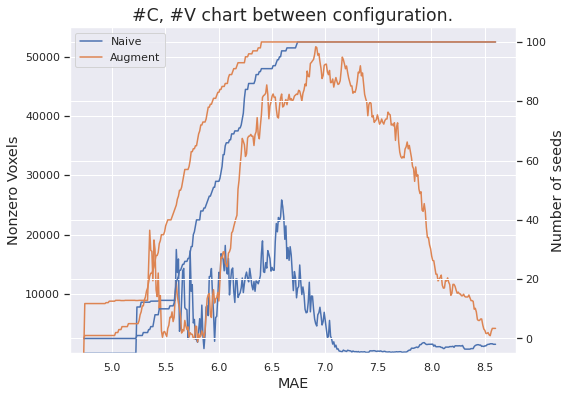

In [23]:
with open("./data/reg_ckpt_data_adjust.pkl", "rb") as f:
    data = pickle.load(f)

fig, ax = plt.subplots(figsize=(8, 6))

adjusted_naive_num = list(map(
    lambda voxel, ckpts: voxel / (51 - ckpts//2)**0.5,
    data["naive_nonzero"],
    data["naive_num_ckpts"]
))
adjusted_augment_num = list(map(
    lambda voxel, ckpts: voxel / (51 - ckpts//2)**0.5,
    data["augment_nonzero"],
    data["augment_num_ckpts"]
))
ax.set_title("#C, #V chart between configuration.", size="x-large")
ax.set_xlabel("MAE", size="large")
ax.set_ylabel("Nonzero Voxels", size="large")
ax.plot(data["MAE"], data["naive_nonzero"], label="Naive")
# ax.plot(data["MAE"], adjusted_naive_num, label="Naive")
ax.plot(data["MAE"], data["augment_nonzero"], label="Augment")
# ax.plot(data["MAE"], adjusted_augment_num, label="Augment")
# ax.tick_params(axis="both", labelsize="large")
ax.set_xlim(4.6)
ax.set_ylim(.1, 55000)

# ax.axvline(7.27, color="red")
# ax.axvline(6.0, color="red")
# ax.axvline(5.4, color="red")
# ax.axvline(4.77, color="red")

ax2 = ax.twinx()

ax2.plot(data["MAE"], data["naive_num_ckpts"], label="Naive")
ax2.plot(data["MAE"], data["augment_num_ckpts"], label="Augment")

ax2.set_ylabel("Number of seeds", size="large")
# ax2.tick_params(axis="y", labelsize="large")
ax2.legend()

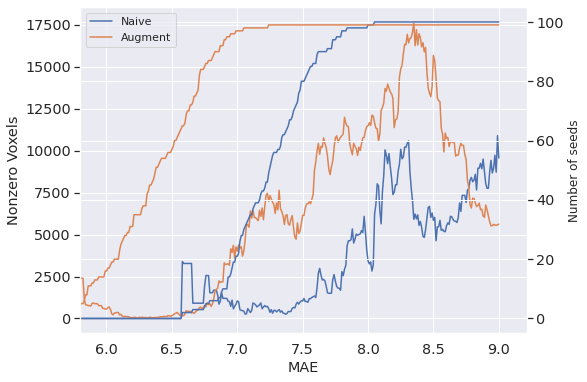

In [71]:
with open("./data/nonreg_ckpt_data.pkl", "rb") as f:
    data = pickle.load(f)

fig, ax = plt.subplots(figsize=(8, 6))

adjusted_naive_num = list(map(
    lambda voxel, ckpts: voxel / (51 - ckpts//2),
    data["naive_nonzero"],
    data["naive_num_ckpts"]
))
adjusted_augment_num = list(map(
    lambda voxel, ckpts: voxel / (51 - ckpts//2),
    data["augment_nonzero"],
    data["augment_num_ckpts"]
))

ax.set_xlabel("MAE", size="large")
ax.set_ylabel("Nonzero Voxels", size="large")
ax.plot(data["MAE"], adjusted_naive_num, label="Naive")
ax.plot(data["MAE"], adjusted_augment_num, label="Augment")

# ax.scatter()
ax.tick_params(axis="both", labelsize="large")
ax.set_xlim(5.8)
# ax.set_ylim(0, 55000)

ax2 = ax.twinx()
ax2.plot(data["MAE"], data["naive_num_ckpts"], label="Naive")
ax2.plot(data["MAE"], data["augment_num_ckpts"], label="Augment")
ax2.set_ylabel("Number of seeds")
ax2.tick_params(axis="y", labelsize="large")
ax2.legend()

Make naive_nonreg Point 8.260424276965955. Selected 100 maps. Average Epoch 8.21 | Average MAE 8.214222850995522.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 9517


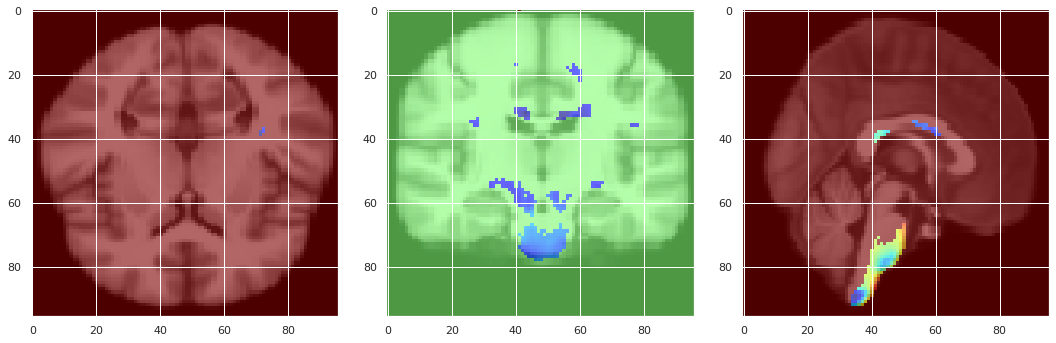

Successfully saved.
Make augment_nonreg Point 8.260424276965955. Selected 99 maps. Average Epoch 6.98989898989899 | Average MAE 8.242855265738644.
99 54
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 30184


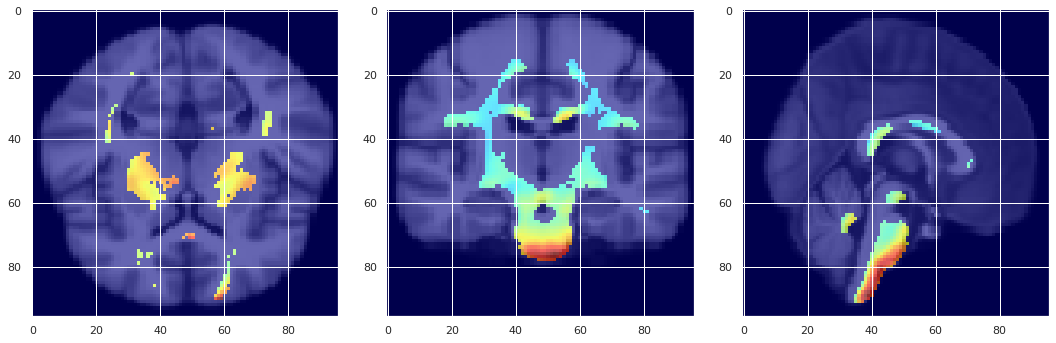

Successfully saved.
******************************
Make naive_nonreg Point 7.860424276965963. Selected 98 maps. Average Epoch 16.336734693877553 | Average MAE 7.836100639295805.
5 41
31 37
Quantile: 0.90 | Agree Threhsold: 49
Nonzero Voxels: 9260


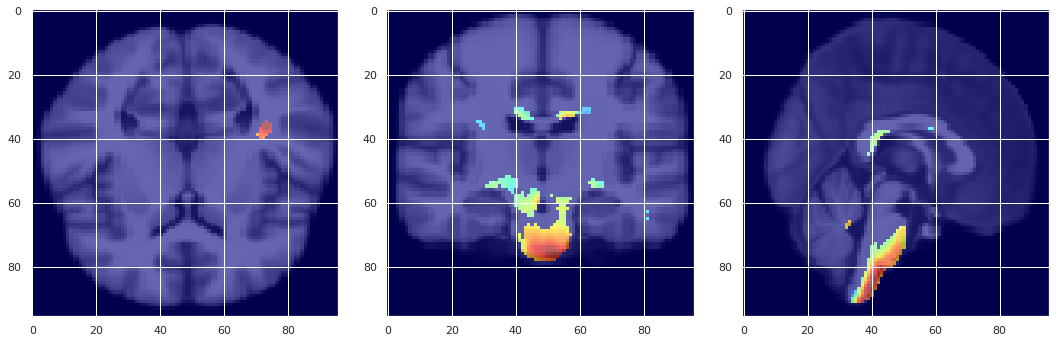

Successfully saved.
Make augment_nonreg Point 7.860424276965963. Selected 99 maps. Average Epoch 10.787878787878787 | Average MAE 7.831585982800253.
99 54
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 20887


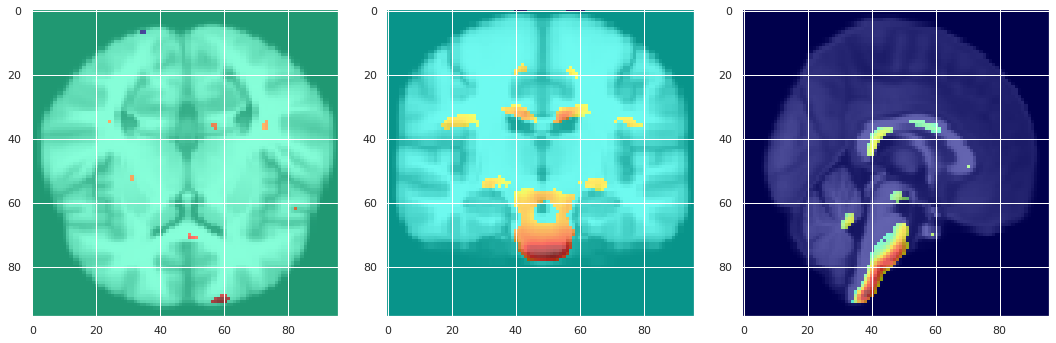

Successfully saved.
******************************
Make naive_nonreg Point 7.250424276965976. Selected 51 maps. Average Epoch 35.94117647058823 | Average MAE 7.226879468759543.
2 75
5 41
7 46
8 42
9 47
11 64
13 44
15 50
16 34
17 48
18 44
20 34
25 36
26 53
27 33
28 57
29 68
31 37
35 43
36 69
37 56
40 50
42 77
43 36
44 32
47 79
54 43
55 63
57 40
60 30
61 56
62 39
63 47
66 60
68 42
69 56
70 73
73 38
76 35
83 26
86 50
87 26
91 28
92 28
93 37
94 41
97 52
98 101
99 35
Quantile: 0.90 | Agree Threhsold: 26
Nonzero Voxels: 9454


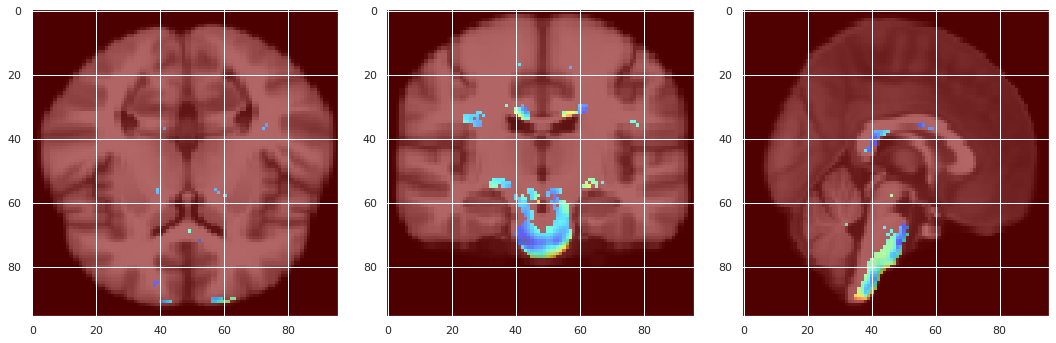

Successfully saved.
Make augment_nonreg Point 7.250424276965976. Selected 99 maps. Average Epoch 22.12121212121212 | Average MAE 7.220056873214382.
99 54
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 14643


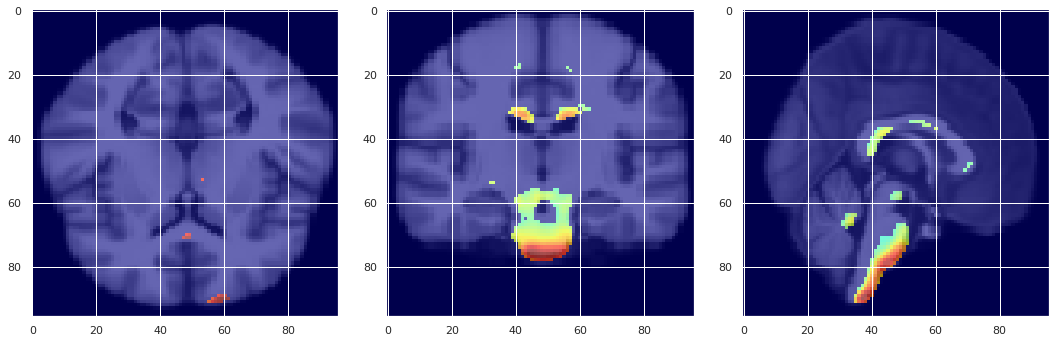

Successfully saved.
******************************
Make naive_nonreg Point 7.0. Selected 21 maps. Average Epoch 43.904761904761905 | Average MAE 6.932377493622562.
2 75
3 75
5 41
6 63
7 46
8 42
9 47
11 64
13 44
14 33
15 50
16 34
17 48
18 44
19 71
20 34
21 44
22 61
23 101
25 36
26 53
27 33
28 57
29 68
31 37
32 28
35 43
36 69
37 56
38 58
39 54
40 50
42 77
43 36
44 32
45 58
46 56
47 79
48 58
50 55
51 53
52 54
54 43
55 63
56 63
57 40
58 68
60 30
61 56
62 39
63 47
66 60
67 37
68 42
69 56
70 73
73 38
74 47
76 35
78 66
79 47
80 67
81 69
82 62
83 26
85 47
86 50
87 26
89 27
90 60
91 28
92 28
93 37
94 41
95 66
96 91
97 52
98 101
99 35
Quantile: 0.90 | Agree Threhsold: 10
Nonzero Voxels: 43006


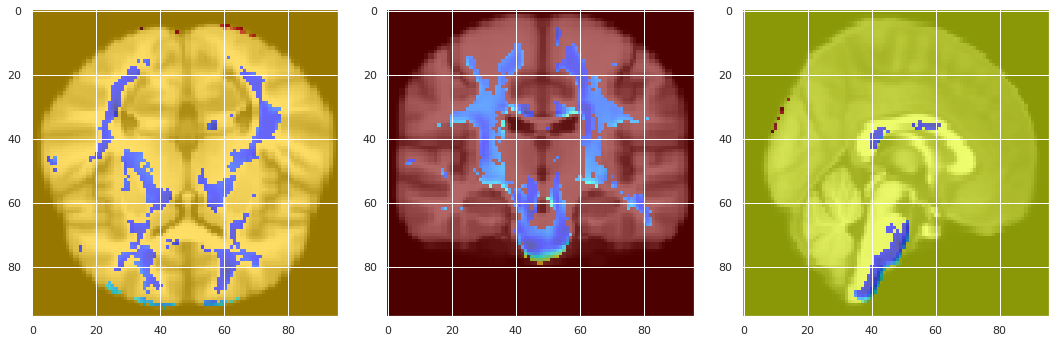

Successfully saved.
Make augment_nonreg Point 7.0. Selected 97 maps. Average Epoch 28.835051546391753 | Average MAE 6.953483075076049.
28 33
69 30
99 54
Quantile: 0.90 | Agree Threhsold: 48
Nonzero Voxels: 12044


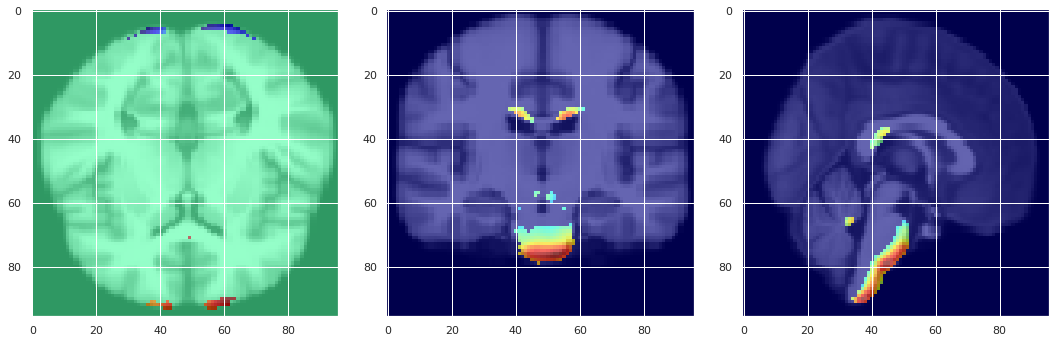

Successfully saved.
******************************
Naive Failed in 6.450424276965993
Make augment_nonreg Point 6.450424276965993. Selected 54 maps. Average Epoch 50.425925925925924 | Average MAE 6.409966997420468.
0 47
3 47
11 39
15 37
17 34
20 35
23 36
24 40
26 54
27 52
28 33
30 31
31 28
32 41
34 57
37 52
39 36
43 56
45 83
47 44
49 44
51 66
55 47
59 46
61 77
63 50
64 44
66 88
68 58
69 30
70 40
71 46
72 67
74 81
76 39
77 52
78 36
81 33
82 40
83 55
90 55
92 45
95 41
96 40
97 53
99 54
Quantile: 0.90 | Agree Threhsold: 27
Nonzero Voxels: 2989


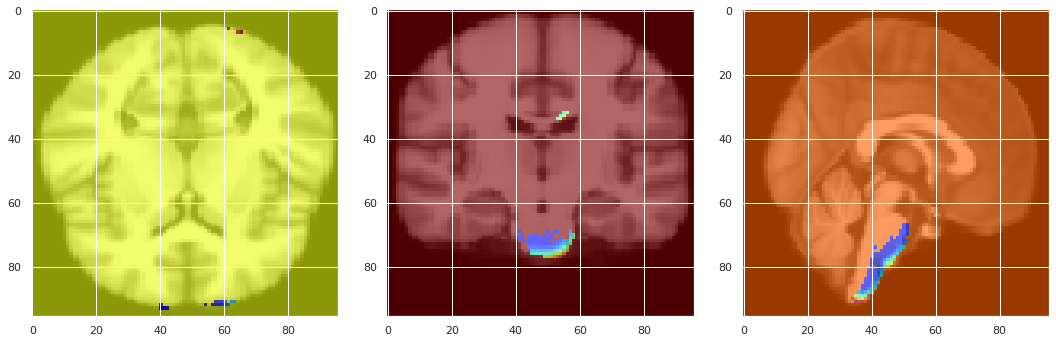

Successfully saved.
******************************
Naive Failed in 6.1
Make augment_nonreg Point 6.1. Selected 23 maps. Average Epoch 62.0 | Average MAE 6.072097953264738.
0 47
2 61
3 47
5 87
9 134
10 59
11 39
12 59
13 56
14 73
15 37
16 72
17 34
18 42
20 35
21 48
23 36
24 40
25 91
26 54
27 52
28 33
29 46
30 31
31 28
32 41
34 57
35 91
37 52
39 36
41 75
42 89
43 56
44 42
45 83
46 119
47 44
48 63
49 44
50 50
51 66
55 47
56 78
59 46
60 63
61 77
62 62
63 50
64 44
66 88
67 55
68 58
69 30
70 40
71 46
72 67
74 81
75 76
76 39
77 52
78 36
81 33
82 40
83 55
84 109
86 112
87 75
88 84
90 55
91 53
92 45
93 65
94 150
95 41
96 40
97 53
99 54
Quantile: 0.90 | Agree Threhsold: 12
Nonzero Voxels: 8427


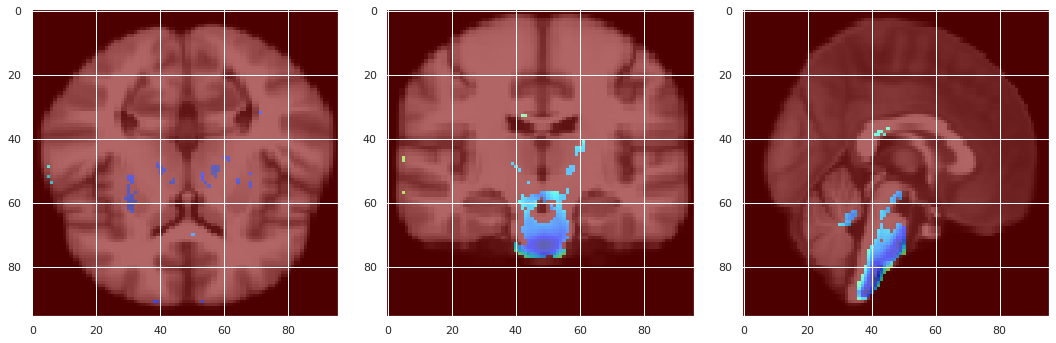

Successfully saved.
******************************
Naive Failed in 5.860424276966006
Make augment_nonreg Point 5.860424276966006. Selected 11 maps. Average Epoch 64.0909090909091 | Average MAE 5.831176621233987.
0 47
1 104
2 61
3 47
4 58
5 87
7 81
9 134
10 59
11 39
12 59
13 56
14 73
15 37
16 72
17 34
18 42
20 35
21 48
23 36
24 40
25 91
26 54
27 52
28 33
29 46
30 31
31 28
32 41
34 57
35 91
37 52
38 77
39 36
41 75
42 89
43 56
44 42
45 83
46 119
47 44
48 63
49 44
50 50
51 66
52 59
54 60
55 47
56 78
57 92
59 46
60 63
61 77
62 62
63 50
64 44
66 88
67 55
68 58
69 30
70 40
71 46
72 67
73 106
74 81
75 76
76 39
77 52
78 36
79 58
80 74
81 33
82 40
83 55
84 109
85 95
86 112
87 75
88 84
90 55
91 53
92 45
93 65
94 150
95 41
96 40
97 53
98 91
99 54
Quantile: 0.90 | Agree Threhsold: 6
Nonzero Voxels: 8928


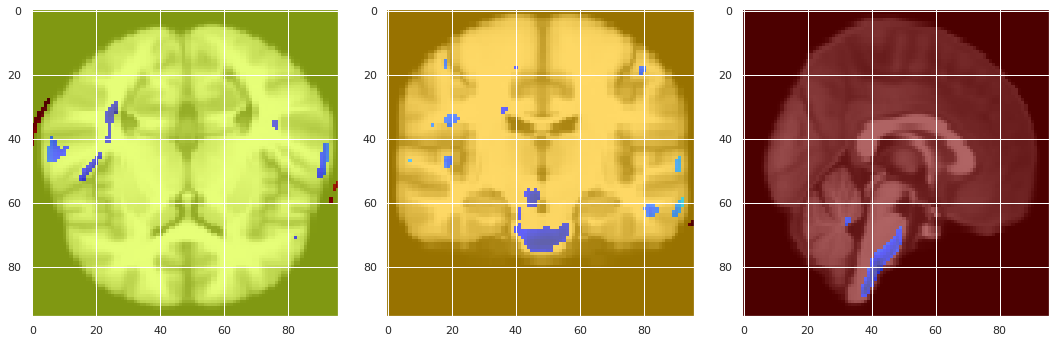

Successfully saved.
******************************


In [77]:
# for point in [53, 45, 23, 8, 7.5, 7, 6.5, 6, 5.5]:
# for point in [53, 45, 23] + [start - (start - end) * ((i+1) / 10) for i in range(10)]:
# for point in [start - (start - end) * ((i+1) / 10) for i in range(10)]:

meta_data = {}
ROOT = "../miccai2022/final(nonreg)"
for idx, point in enumerate(nonreg_ckpt):

    try:
        naive_cut, naive_num_maps = make_maeckpt_maps("naive_nonreg", point)
        # make_soft_thresholded_map(naive_cut, quantile);
        naive_hard, naive_nonzero = exp_quantile_agree(naive_cut, .9, round(naive_num_maps / 2), blur=False);
        save2nifti(naive_hard, f"{ROOT}/naive_hard_{idx}.nii")
    except ZeroDivisionError:
        print(f"Naive Failed in {point}")
        naive_num_maps, naive_nonzero = 0, 0
        pass

    try:
        augment_cut, augment_num_maps = make_maeckpt_maps("augment_nonreg", point)
        # make_soft_thresholded_map(augment_cut, quantile);
        augment_hard, augment_nonzero = exp_quantile_agree(augment_cut, .9, round(augment_num_maps / 2), blur=False);
        save2nifti(augment_hard, f"{ROOT}/augment_hard_{idx}.nii")
    except ZeroDivisionError:
        print(f"Augment Failed in {point}")
        augment_num_maps, augment_nonzero = 0, 0
        pass

    meta_data[idx] = {
        "mae": point,
        "naive": {
            "naive_num_maps": naive_num_maps,
            "naive_nonzero_voxels": naive_nonzero,
        },
        "augment": {
            "augment_num_maps": augment_num_maps,
            "augment_nonzero_voxels": augment_nonzero,
        },
    }

    print(f"{'*' *  30}")

with open(f"{ROOT}/meta_data.yml", "w") as f:
    yaml.dump(meta_data, f)

In [59]:
meta_data

{0: {'mae': 7.891866127693504,
  'naive': {'naive_num_maps': 100, 'naive_nonzero_voxels': 1466},
  'augment': {'augment_num_maps': 100, 'augment_nonzero_voxels': 26938}},
 1: {'mae': 7.271866127693517,
  'naive': {'naive_num_maps': 100, 'naive_nonzero_voxels': 295},
  'augment': {'augment_num_maps': 100, 'augment_nonzero_voxels': 44124}},
 2: {'mae': 6.501866127693534,
  'naive': {'naive_num_maps': 91, 'naive_nonzero_voxels': 14477},
  'augment': {'augment_num_maps': 100, 'augment_nonzero_voxels': 43348}},
 3: {'mae': 6.0,
  'naive': {'naive_num_maps': 53, 'naive_nonzero_voxels': 12554},
  'augment': {'augment_num_maps': 83, 'augment_nonzero_voxels': 8355}},
 4: {'mae': 5.661866127693552,
  'naive': {'naive_num_maps': 25, 'naive_nonzero_voxels': 13893},
  'augment': {'augment_num_maps': 53, 'augment_nonzero_voxels': 3998}},
 5: {'mae': 5.2918661276935595,
  'naive': {'naive_num_maps': 0, 'naive_nonzero_voxels': 0},
  'augment': {'augment_num_maps': 0, 'augment_nonzero_voxels': 0}},
 6:

Make naive Point 7.891866127693504. Selected 100 maps. Average Epoch 4.04 | Average MAE 7.823679864635207.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 1466


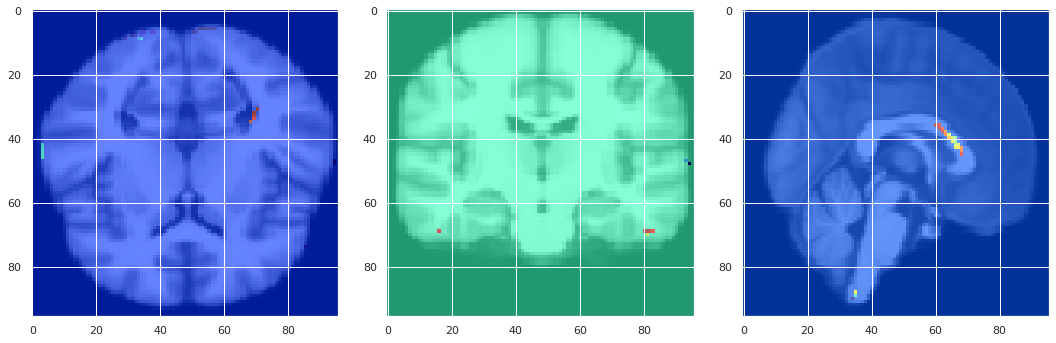

Successfully saved.
Make augment Point 7.891866127693504. Selected 100 maps. Average Epoch 6.49 | Average MAE 7.889359608088455.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 26938


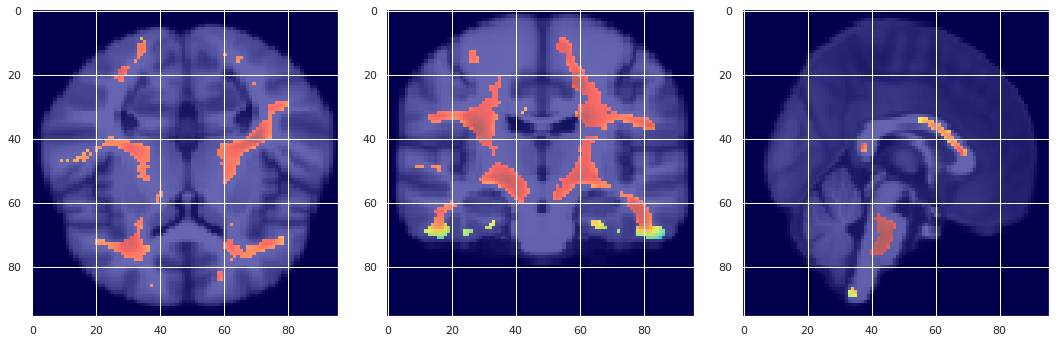

Successfully saved.
******************************
Make naive Point 7.271866127693517. Selected 100 maps. Average Epoch 6.13 | Average MAE 7.245501398844262.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 295


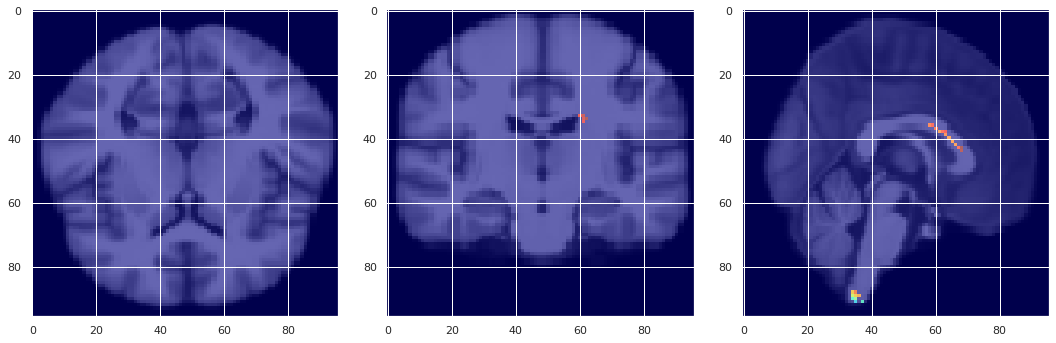

Successfully saved.
Make augment Point 7.271866127693517. Selected 100 maps. Average Epoch 10.54 | Average MAE 7.232166237373876.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 44124


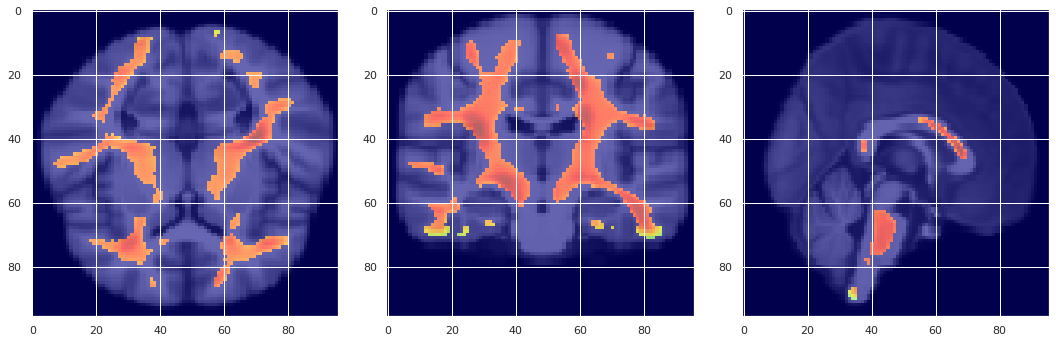

Successfully saved.
******************************
Make naive Point 6.501866127693534. Selected 91 maps. Average Epoch 18.582417582417584 | Average MAE 6.454384949486175.
13 32
24 35
27 49
43 37
56 31
58 29
67 28
71 34
82 49
Quantile: 0.90 | Agree Threhsold: 46
Nonzero Voxels: 14477


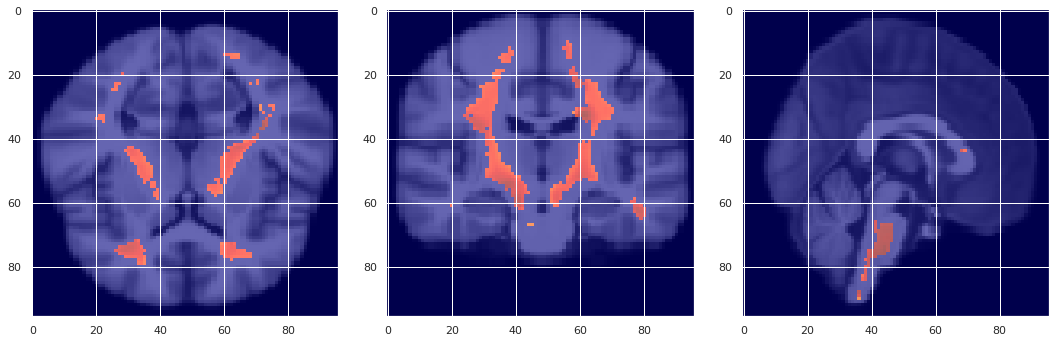

Successfully saved.
Make augment Point 6.501866127693534. Selected 100 maps. Average Epoch 23.36 | Average MAE 6.488635617870176.
Quantile: 0.90 | Agree Threhsold: 50
Nonzero Voxels: 43348


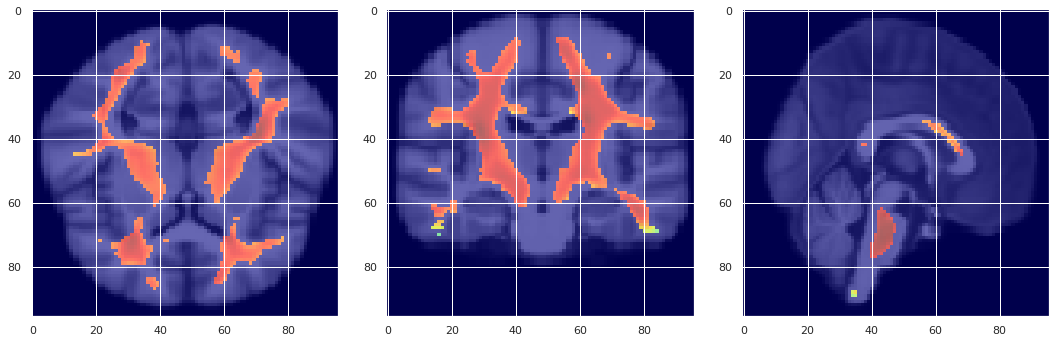

Successfully saved.
******************************
Make naive Point 6.0. Selected 53 maps. Average Epoch 36.528301886792455 | Average MAE 5.929971446976177.
5 38
8 42
10 63
11 37
13 32
14 42
17 47
19 34
20 65
23 43
24 35
25 34
26 45
27 49
29 34
30 33
31 30
40 37
41 48
42 27
43 37
44 40
46 45
47 45
50 86
51 34
54 48
55 80
56 31
58 29
60 37
62 51
65 58
67 28
68 43
70 50
71 34
75 63
80 38
81 48
82 49
87 54
90 51
91 39
93 41
95 53
97 52
Quantile: 0.90 | Agree Threhsold: 26
Nonzero Voxels: 12554


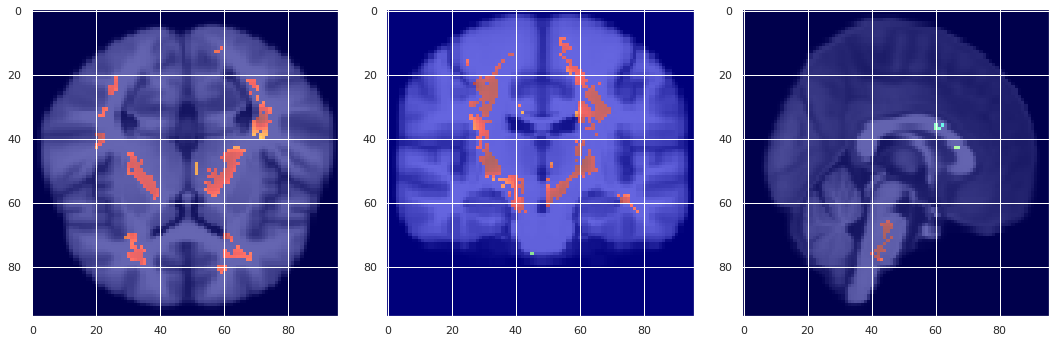

Successfully saved.
Make augment Point 6.0. Selected 83 maps. Average Epoch 36.86746987951807 | Average MAE 5.973866788521322.
0 39
5 40
10 29
14 66
17 44
18 46
20 49
29 53
30 50
41 59
44 35
47 66
67 45
70 52
72 35
89 62
96 42
Quantile: 0.90 | Agree Threhsold: 42
Nonzero Voxels: 8355


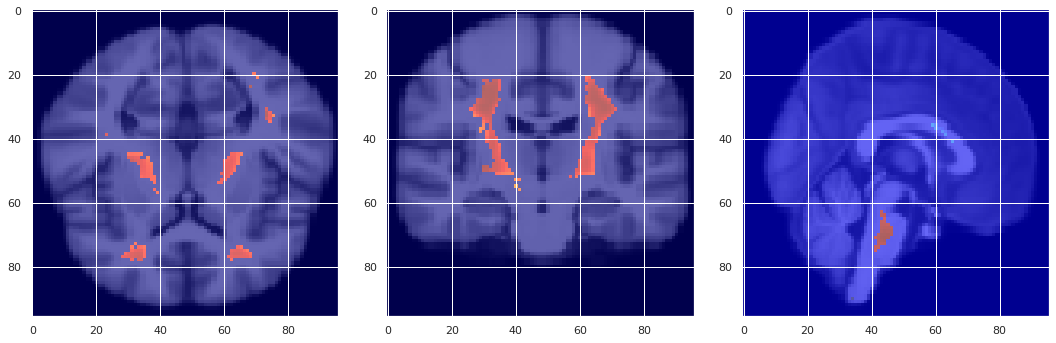

Successfully saved.
******************************
Make naive Point 5.661866127693552. Selected 25 maps. Average Epoch 47.2 | Average MAE 5.636091802936711.
0 97
3 44
5 38
6 49
8 42
10 63
11 37
13 32
14 42
15 47
17 47
18 66
19 34
20 65
23 43
24 35
25 34
26 45
27 49
29 34
30 33
31 30
32 43
37 72
38 93
40 37
41 48
42 27
43 37
44 40
46 45
47 45
48 73
50 86
51 34
52 51
54 48
55 80
56 31
57 65
58 29
59 65
60 37
61 82
62 51
65 58
66 39
67 28
68 43
69 62
70 50
71 34
72 98
73 62
74 104
75 63
77 50
78 59
79 32
80 38
81 48
82 49
85 60
86 50
87 54
89 60
90 51
91 39
92 72
93 41
94 48
95 53
96 58
97 52
99 60
Quantile: 0.90 | Agree Threhsold: 12
Nonzero Voxels: 13893


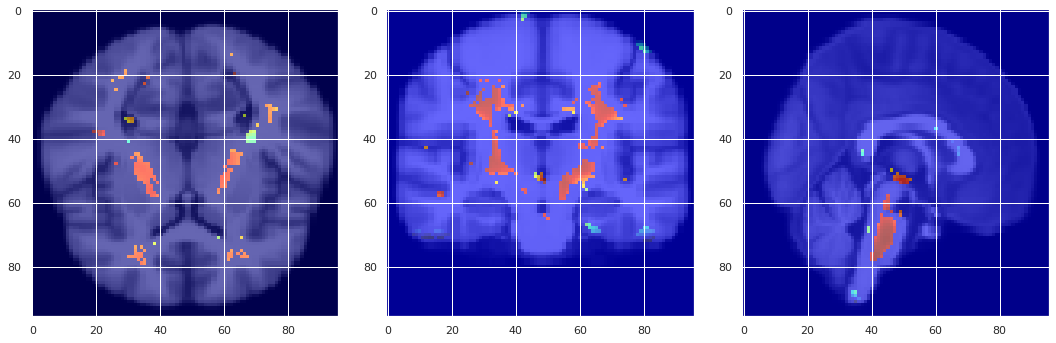

Successfully saved.
Make augment Point 5.661866127693552. Selected 53 maps. Average Epoch 46.37735849056604 | Average MAE 5.6384980669314935.
0 39
4 52
5 40
8 93
10 29
12 44
14 66
17 44
18 46
19 60
20 49
24 57
27 53
28 109
29 53
30 50
33 150
34 84
36 41
37 100
38 55
41 59
44 35
46 74
47 66
48 52
53 60
55 49
56 89
59 78
61 59
65 54
66 43
67 45
70 52
71 53
72 35
73 62
79 60
80 43
81 47
84 61
88 82
89 62
92 68
93 68
96 42
Quantile: 0.90 | Agree Threhsold: 26
Nonzero Voxels: 3998


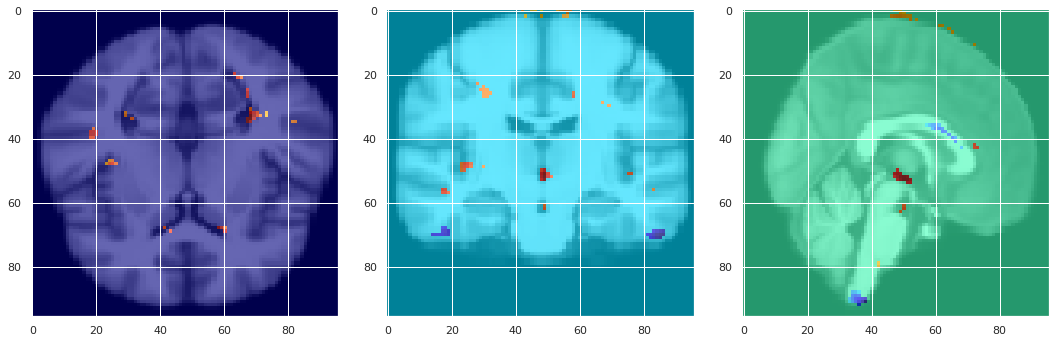

Successfully saved.
******************************
Make naive Point 5.4. Selected 7 maps. Average Epoch 53.42857142857143 | Average MAE 5.344063671134457.
0 97
2 104
3 44
5 38
6 49
7 72
8 42
9 55
10 63
11 37
12 67
13 32
14 42
15 47
16 86
17 47
18 66
19 34
20 65
21 69
23 43
24 35
25 34
26 45
27 49
28 51
29 34
30 33
31 30
32 43
33 70
35 47
36 39
37 72
38 93
40 37
41 48
42 27
43 37
44 40
45 47
46 45
47 45
48 73
49 74
50 86
51 34
52 51
53 62
54 48
55 80
56 31
57 65
58 29
59 65
60 37
61 82
62 51
63 120
64 55
65 58
66 39
67 28
68 43
69 62
70 50
71 34
72 98
73 62
74 104
75 63
77 50
78 59
79 32
80 38
81 48
82 49
83 78
85 60
86 50
87 54
88 58
89 60
90 51
91 39
92 72
93 41
94 48
95 53
96 58
97 52
98 69
99 60
Quantile: 0.90 | Agree Threhsold: 4
Nonzero Voxels: 8806


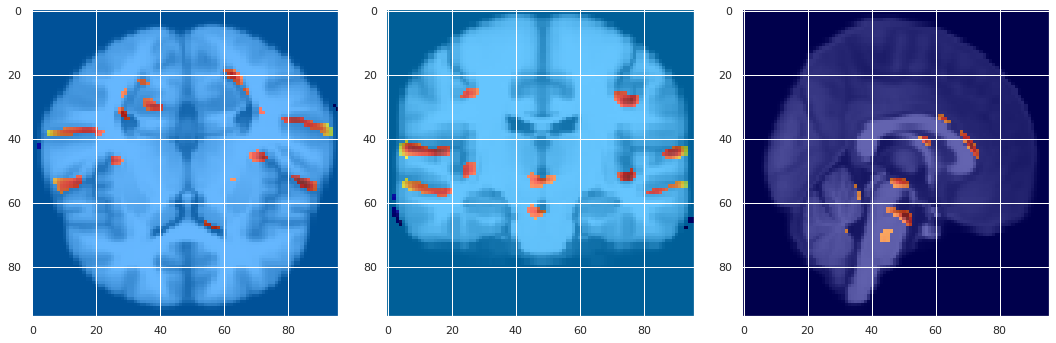

Successfully saved.
Make augment Point 5.4. Selected 26 maps. Average Epoch 57.03846153846154 | Average MAE 5.353493866855151.
0 39
3 54
4 52
5 40
7 63
8 93
10 29
11 53
12 44
14 66
16 78
17 44
18 46
19 60
20 49
21 85
22 65
23 91
24 57
25 61
27 53
28 109
29 53
30 50
33 150
34 84
36 41
37 100
38 55
40 94
41 59
44 35
45 78
46 74
47 66
48 52
50 98
51 83
53 60
54 60
55 49
56 89
57 74
58 74
59 78
60 74
61 59
63 88
64 59
65 54
66 43
67 45
68 46
69 101
70 52
71 53
72 35
73 62
74 39
76 77
78 72
79 60
80 43
81 47
82 83
84 61
88 82
89 62
92 68
93 68
94 96
95 67
96 42
98 59
Quantile: 0.90 | Agree Threhsold: 13
Nonzero Voxels: 17472


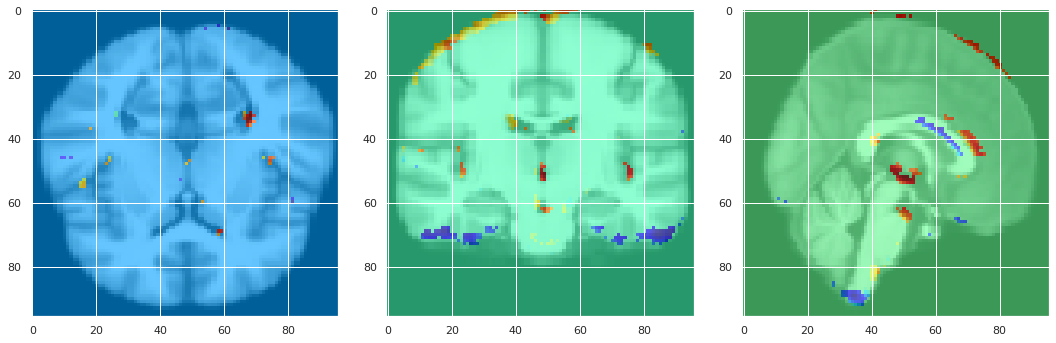

Successfully saved.
******************************
Make naive Point 5.2918661276935595. Selected 2 maps. Average Epoch 37.0 | Average MAE 5.27514482524297.
0 97
1 62
2 104
3 44
4 73
5 38
6 49
7 72
8 42
9 55
10 63
11 37
12 67
13 32
14 42
15 47
16 86
17 47
18 66
19 34
20 65
21 69
22 64
23 43
24 35
25 34
26 45
27 49
28 51
29 34
30 33
31 30
32 43
33 70
34 79
35 47
36 39
37 72
38 93
40 37
41 48
42 27
43 37
44 40
45 47
46 45
47 45
48 73
49 74
50 86
51 34
52 51
53 62
54 48
55 80
56 31
57 65
58 29
59 65
60 37
61 82
62 51
63 120
64 55
65 58
66 39
67 28
68 43
69 62
70 50
71 34
72 98
73 62
74 104
75 63
77 50
78 59
79 32
80 38
81 48
82 49
83 78
84 108
85 60
86 50
87 54
88 58
89 60
90 51
91 39
92 72
93 41
94 48
95 53
96 58
97 52
98 69
99 60
Quantile: 0.90 | Agree Threhsold: 1
Nonzero Voxels: 8618


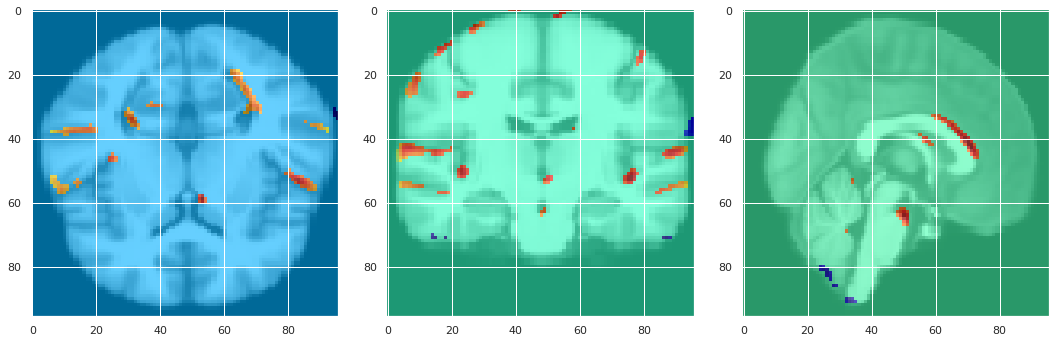

Successfully saved.
Make augment Point 5.2918661276935595. Selected 11 maps. Average Epoch 63.09090909090909 | Average MAE 5.261716350968718.
0 39
1 74
2 85
3 54
4 52
5 40
6 64
7 63
8 93
10 29
11 53
12 44
14 66
16 78
17 44
18 46
19 60
20 49
21 85
22 65
23 91
24 57
25 61
27 53
28 109
29 53
30 50
31 67
32 81
33 150
34 84
36 41
37 100
38 55
39 57
40 94
41 59
42 69
43 68
44 35
45 78
46 74
47 66
48 52
49 84
50 98
51 83
53 60
54 60
55 49
56 89
57 74
58 74
59 78
60 74
61 59
62 93
63 88
64 59
65 54
66 43
67 45
68 46
69 101
70 52
71 53
72 35
73 62
74 39
75 97
76 77
77 44
78 72
79 60
80 43
81 47
82 83
83 71
84 61
86 110
88 82
89 62
92 68
93 68
94 96
95 67
96 42
97 57
98 59
Quantile: 0.90 | Agree Threhsold: 6
Nonzero Voxels: 8928


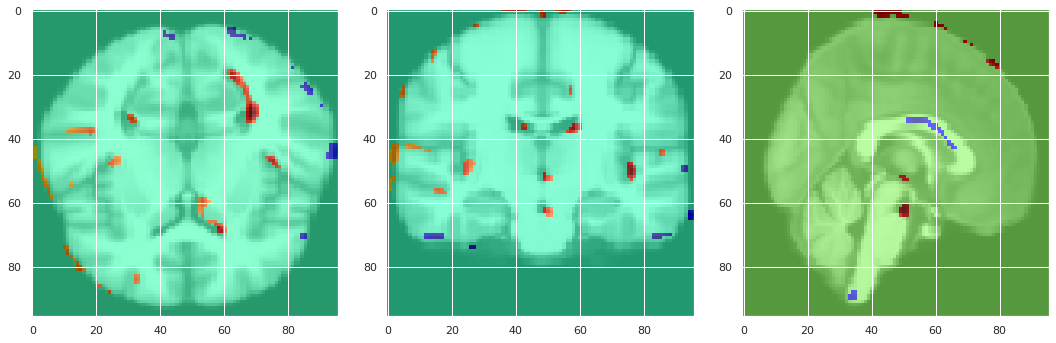

Successfully saved.
******************************
Naive Failed in 5.221866127693561
Make augment Point 5.221866127693561. Selected 5 maps. Average Epoch 73.6 | Average MAE 5.173999548611576.
0 39
1 74
2 85
3 54
4 52
5 40
6 64
7 63
8 93
10 29
11 53
12 44
13 73
14 66
16 78
17 44
18 46
19 60
20 49
21 85
22 65
23 91
24 57
25 61
27 53
28 109
29 53
30 50
31 67
32 81
33 150
34 84
35 92
36 41
37 100
38 55
39 57
40 94
41 59
42 69
43 68
44 35
45 78
46 74
47 66
48 52
49 84
50 98
51 83
52 51
53 60
54 60
55 49
56 89
57 74
58 74
59 78
60 74
61 59
62 93
63 88
64 59
65 54
66 43
67 45
68 46
69 101
70 52
71 53
72 35
73 62
74 39
75 97
76 77
77 44
78 72
79 60
80 43
81 47
82 83
83 71
84 61
85 53
86 110
87 110
88 82
89 62
92 68
93 68
94 96
95 67
96 42
97 57
98 59
99 65
Quantile: 0.90 | Agree Threhsold: 2
Nonzero Voxels: 8901


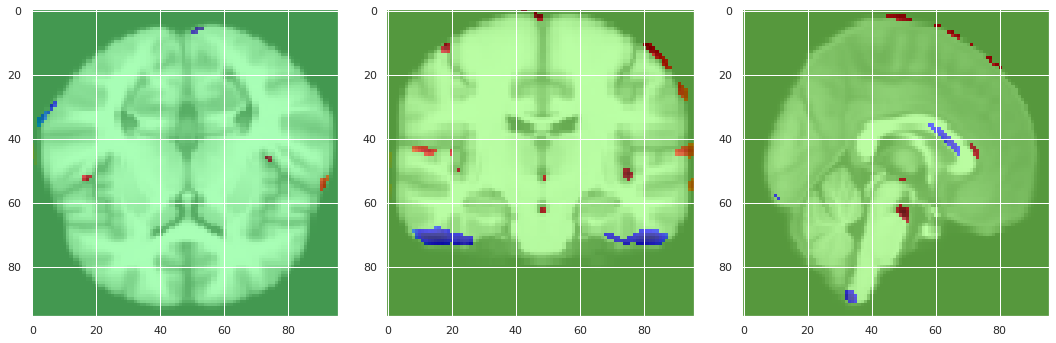

Successfully saved.
******************************
Naive Failed in 4.7718661276935705
Make augment Point 4.7718661276935705. Selected 1 maps. Average Epoch 100.0 | Average MAE 4.733679967383816.
0 39
1 74
2 85
3 54
4 52
5 40
6 64
7 63
8 93
9 89
10 29
11 53
12 44
13 73
14 66
15 130
16 78
17 44
18 46
19 60
20 49
21 85
22 65
23 91
24 57
25 61
26 112
27 53
28 109
29 53
30 50
31 67
32 81
33 150
34 84
35 92
36 41
37 100
38 55
39 57
40 94
41 59
42 69
43 68
44 35
45 78
46 74
47 66
48 52
49 84
50 98
51 83
52 51
53 60
54 60
55 49
56 89
57 74
58 74
59 78
60 74
61 59
62 93
63 88
64 59
65 54
66 43
67 45
68 46
69 101
70 52
71 53
72 35
73 62
74 39
75 97
76 77
77 44
78 72
79 60
80 43
81 47
82 83
83 71
84 61
85 53
86 110
87 110
88 82
89 62
90 73
92 68
93 68
94 96
95 67
96 42
97 57
98 59
99 65
Quantile: 0.90 | Agree Threhsold: 0
Nonzero Voxels: 8388


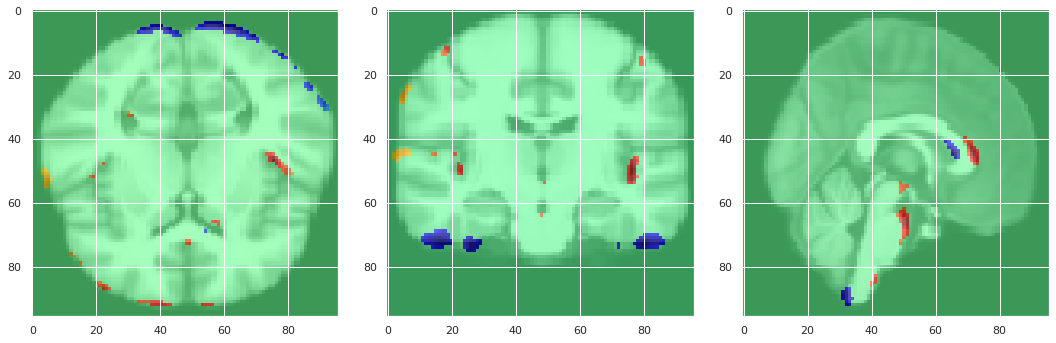

Successfully saved.
******************************


In [73]:
# for point in [53, 45, 23, 8, 7.5, 7, 6.5, 6, 5.5]:
# for point in [53, 45, 23] + [start - (start - end) * ((i+1) / 10) for i in range(10)]:
# for point in [start - (start - end) * ((i+1) / 10) for i in range(10)]:

meta_data = {}
ROOT = "../miccai2022/final"
for idx, point in enumerate(ckpt):

    try:
        naive_cut, naive_num_maps = make_maeckpt_maps("naive", point)
        # make_soft_thresholded_map(naive_cut, quantile);
        naive_hard, naive_nonzero = exp_quantile_agree(naive_cut, .9, round(naive_num_maps / 2), blur=False);
        save2nifti(naive_hard, f"{ROOT}/naive_hard_{idx}.nii")
    except ZeroDivisionError:
        print(f"Naive Failed in {point}")
        naive_num_maps, naive_nonzero = 0, 0
        pass

    try:
        augment_cut, augment_num_maps = make_maeckpt_maps("augment", point)
        # make_soft_thresholded_map(augment_cut, quantile);
        augment_hard, augment_nonzero = exp_quantile_agree(augment_cut, .9, round(augment_num_maps / 2), blur=False);
        save2nifti(augment_hard, f"{ROOT}/augment_hard_{idx}.nii")
    except ZeroDivisionError:
        print(f"Augment Failed in {point}")
        augment_num_maps, augment_nonzero = 0, 0
        pass

    meta_data[idx] = {
        "mae": point,
        "naive": {
            "naive_num_maps": naive_num_maps,
            "naive_nonzero_voxels": naive_nonzero,
        },
        "augment": {
            "augment_num_maps": augment_num_maps,
            "augment_nonzero_voxels": augment_nonzero,
        },
    }

    print(f"{'*' *  30}")

with open(f"{ROOT}/meta_data.yml", "w") as f:
    yaml.dump(meta_data, f)

In [56]:
with open(f"{ROOT}/meta_data.yml", "w") as f:
    yaml.dump(meta_data, f)